In [27]:
!pip install tensorflow

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, Layer, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [29]:
# 데이터 불러오기
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)


In [30]:
# 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(df[['y']])


In [31]:
# 시퀀스 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [32]:
SEQ_LEN = 12  # 12개월 사용해서 다음 달 예측
X, y = create_sequences(data, SEQ_LEN)

In [33]:
# 학습 / 테스트 분리
split = len(X) - 12
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [52]:
class PositionalEncoding(Layer):
    def __init__(self, seq_len, embed_dim):
        super().__init__()
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embed_dim))
        angle_rads = pos * angle_rates
        # sin, cos 분리
        pos_encoding = np.zeros((seq_len, embed_dim))
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [34]:
# Transformer Block 정의
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):  # 기본값 None 추가
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [35]:
# 입력 크기 설정
embed_dim = 32  # 임베딩 차원
num_heads = 2   # 어텐션 헤드 수
ff_dim = 64     # Feed-forward 네트워크 차원


In [55]:
inputs = Input(shape=(SEQ_LEN, 1))
x = Dense(embed_dim)(inputs)
x = PositionalEncoding(SEQ_LEN, embed_dim)(x)

for _ in range(2):  # Transformer 블록 3개 쌓기 (원래 1개 + 2개 추가)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1)(x)

In [56]:
model = Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss="mse")

# 학습
model.fit(X_train, y_train, epochs=300, batch_size=8, verbose=0)


In [58]:
# 예측 및 복원
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)
y_test_true = scaler.inverse_transform(y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


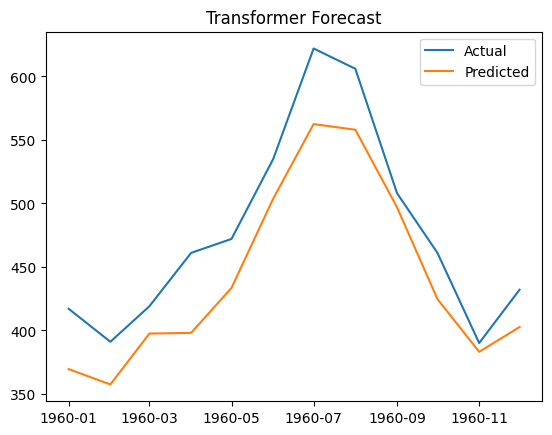

In [59]:
# 시각화
test_index = df.index[-len(y_test):]
plt.plot(test_index, y_test_true, label='Actual')
plt.plot(test_index, pred, label='Predicted')
plt.legend()
plt.title("Transformer Forecast")
plt.show()


In [60]:
# RMSE 출력
rmse = np.sqrt(mean_squared_error(y_test_true, pred))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 39.26


트랜스포머는 CNN, LSTM에 비해 훨씬 많은 양의 데이터를 필요로 함
또한 복잡한 feature 간 모델링에 강력, 입력이 단순하면 효과 없음
따라서 CNN, LSTM에 비해 성능이 좋지 않게 나왔음